# Using RL to Model Cognitive Tasks

**By Neurmatch Academy**

__Content creators:__ Morteza Ansarinia, Yamil Vidal, Mobin Nesari

__Production editor:__ Spiros Chavlis


---
# Objective

- This project aims to use behavioral data to train an agent and then use the agent to investigate data produced by human subjects. Having a computational agent that mimics humans in such tests, we will be able to compare its mechanics with human data.

- In another conception, we could fit an agent that learns many cognitive tasks that require abstract-level constructs such as executive functions. This is a multi-task control problem.




---
# Setup

In [1]:
# @title Install dependencies
!pip install gymnasium stable-baselines3[extra] matplotlib --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 132.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 15.5 MB/s eta 0:00:00


In [2]:
# @title Imports
# Standard Library Imports
import os
import time

# Third-Party Library Imports
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

# Specific Submodule Imports
from gymnasium import spaces
from IPython.display import clear_output, display, HTML
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env


In [3]:
# @title Figure configs
from IPython.display import clear_output, display, HTML
%matplotlib inline
sns.set()

In [4]:
# @title Make directories
log_dir = "./tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

In [5]:
# @title Plotter function
def plot_training_results(log_folder, title='Learning Curve'):
    """
    Plots the training results from a Monitor log file.
    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')

    # The reward in our env is max 32 (1 per step)
    # We can calculate accuracy from this
    y_acc = (np.array(y) / 32.0) * 100

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Plot 1: Episode Rewards
    ax1.plot(x, y, color='blue')
    ax1.set_title(title)
    ax1.set_ylabel('Episode Reward')
    ax1.grid(True)

    # Plot a rolling average for rewards
    y_rolling = pd.Series(y).rolling(50).mean()
    ax1.plot(x, y_rolling, color='red', linewidth=2, label='Rolling Avg (50 episodes)')
    ax1.legend()

    # Plot 2: Episode Accuracy
    ax2.plot(x, y_acc, color='green')
    ax2.set_ylabel('Episode Accuracy (%)')
    ax2.set_xlabel('Timesteps')
    ax2.grid(True)

    # Plot a rolling average for accuracy
    y_acc_rolling = pd.Series(y_acc).rolling(50).mean()
    ax2.plot(x, y_acc_rolling, color='orange', linewidth=2, label='Rolling Avg (50 episodes)')
    ax2.legend()

    plt.tight_layout()
    plt.show()

---
# Background

- Cognitive scientists use standard lab tests to tap into specific processes in the brain and behavior. Some examples of those tests are Stroop, N-back, Digit Span, TMT (Trail making tests), and WCST (Wisconsin Card Sorting Tests).

- Despite an extensive body of research that explains human performance using descriptive what-models, we still need a more sophisticated approach to gain a better understanding of the underlying processes (i.e., a how-model).

- Interestingly, many of such tests can be thought of as a continuous stream of stimuli and corresponding actions, that is in consonant with the RL formulation. In fact, RL itself is in part motivated by how the brain enables goal-directed behaviors using reward systems, making it a good choice to explain human performance.

- One behavioral test example would be the N-back task.

  - In the N-back, participants view a sequence of stimuli, one by one, and are asked to categorize each stimulus as being either match or non-match. Stimuli are usually numbers, and feedback is given at both timestep and trajectory levels.

  - The agent is rewarded when its response matches the stimulus that was shown N steps back in the episode. A simpler version of the N-back uses two-choice action schema, that is match vs non-match. Once the present stimulus matches the one presented N step back, then the agent is expected to respond to it as being a `match`.


- Given a trained RL agent, we then find correlates of its fitted parameters with the brain mechanisms. The most straightforward composition could be the correlation of model parameters with the brain activities.

## Datasets

- HCP WM task ([NMA-CN HCP notebooks](https://github.com/NeuromatchAcademy/course-content/tree/master/projects/fMRI))

Any dataset that used cognitive tests would work.
Question: limit to behavioral data vs fMRI?
Question: Which stimuli and actions to use?
classic tests can be modeled using 1) bounded symbolic stimuli/actions (e.g., A, B, C), but more sophisticated one would require texts or images (e.g., face vs neutral images in social stroop dataset)
The HCP dataset from NMA-CN contains behavioral and imaging data for 7 cognitive tests including various versions of N-back.

---
# Cognitive Tests Environment

First we develop an environment in that agents perform a cognitive test, here the N-back.

## Human dataset

We need a dataset of human perfoming a N-back test, with the following features:

- `participant_id`: following the BIDS format, it contains a unique identifier for each participant.
- `trial_index`: same as `time_step`.
- `stimulus`: same as `observation`.
- `response`: same as `action`, recorded response by the human subject.
- `expected_response`: correct response.
- `is_correct`: same as `reward`, whether the human subject responded correctly.
- `response_time`: won't be used here.

Here we generate a mock dataset with those features, but remember to **replace this with real human data.**

In [6]:
def generate_mock_nback_dataset(N=2,
                                n_participants=10,
                                n_trials=32,
                                stimulus_choices=list('ABCDEF'),
                                response_choices=['match', 'non-match']):
  """Generate a mock dataset for the N-back task."""
  n_rows = n_participants * n_trials
  participant_ids = sorted([f'sub-{pid}' for pid in range(1, n_participants + 1)] * n_trials)
  trial_indices = list(range(1, n_trials + 1)) * n_participants
  stimulus_sequence = np.random.choice(stimulus_choices, n_rows)
  responses = np.random.choice(response_choices, n_rows)
  response_times = np.random.exponential(size=n_rows)
  df = pd.DataFrame({
      'participant_id': participant_ids,
      'trial_index': trial_indices,
      'stimulus': stimulus_sequence,
      'response': responses,
      'response_time': response_times
  })
  # Mark matching stimuli
  nbackstim = df['stimulus'].shift(N)
  df['expected_response'] = (df['stimulus'] == nbackstim).map({True: 'match', False: 'non-match'})
  df['is_correct'] = (df['response'] == df['expected_response'])
  # We don't care about burn-in trials (trial < N)
  df.loc[df['trial_index'] <= N, 'is_correct'] = True
  df.loc[df['trial_index'] <= N, ['response', 'response_time', 'expected_response']] = None
  return df

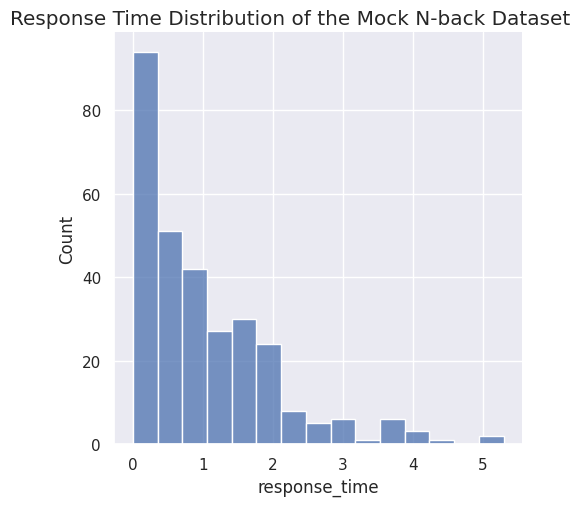

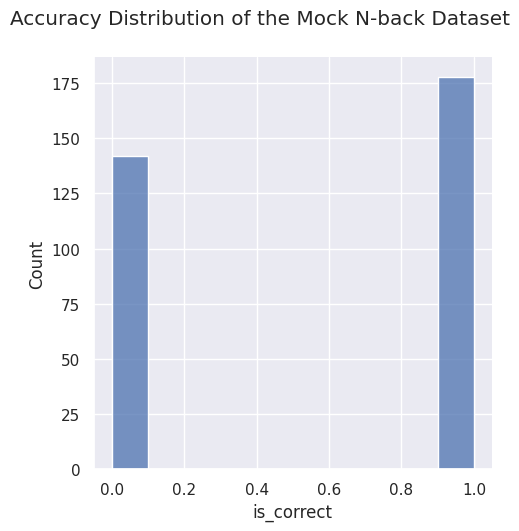

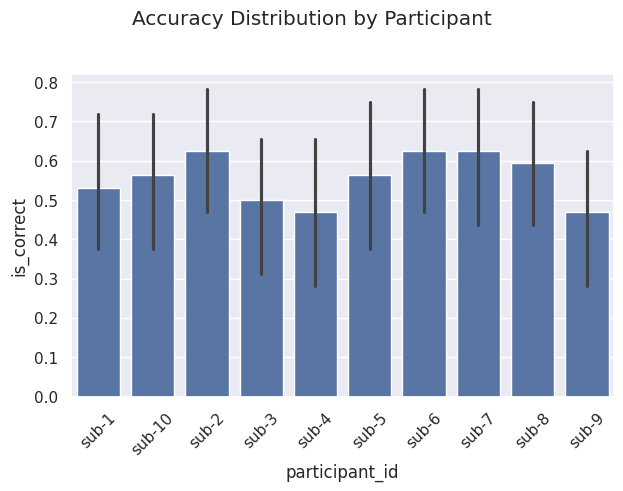

In [7]:
# ========
# Generate the actual data with the provided function and plot some of its features
mock_nback_data = generate_mock_nback_dataset()
mock_nback_data['is_correct'] = mock_nback_data['is_correct'].astype(int)

# Plot response time distribution
sns.displot(data=mock_nback_data, x='response_time')
plt.suptitle('Response Time Distribution of the Mock N-back Dataset', y=1.01)
plt.show()

# Plot accuracy distribution
sns.displot(data=mock_nback_data, x='is_correct')
plt.suptitle('Accuracy Distribution of the Mock N-back Dataset', y=1.06)
plt.show()

# Plot accuracy by participant
sns.barplot(data=mock_nback_data, y='is_correct', x='participant_id')
plt.suptitle('Accuracy Distribution by Participant', y=1.02)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
# Display the first few rows of the dataframe
mock_nback_data.head()

,participant_id,trial_index,stimulus,response,response_time,expected_response,is_correct
0,sub-1,1,D,None,NaN,None,1
1,sub-1,2,C,None,NaN,None,1
2,sub-1,3,F,match,0.081122,non-match,0
3,sub-1,4,E,match,1.267059,non-match,0
4,sub-1,5,B,non-match,0.432648,non-match,1


### Environment

The following cell implments N-back envinronment, that we later use to train a RL agent on human data. It is capable of performing two kinds of simulation:
- rewards the agent once the action was correct (i.e., a normative model of the environment).
- receives human data (or mock data if you prefer), and returns what participants performed as the observation. This is more useful for preference-based RL.

In [9]:
class NBack(gym.Env):
    """
    An N-Back task environment compatible with the Gymnasium API.

    The agent's goal is to determine if the current stimulus matches the one
    presented N steps ago.

    Observation:
        A numpy array of size (episode_steps,), containing the stimuli
        presented up to the current step, padded with zeros for future steps.
        Stimuli are encoded as integers.

    Actions:
        0: 'non-match'
        1: 'match'

    Reward:
        +1 for each correct action.
        0 for each incorrect action.
    """
    metadata = {'render_modes': ['human']}
    ACTIONS = {0: 'non-match', 1: 'match'} # Flipped for easier indexing

    def __init__(self,
                 N=2,
                 episode_steps=32,
                 stimuli_choices=6, # Number of distinct stimuli, e.g., 6 for 'A'-'F'
                 human_data=None,
                 seed=None):
        """
        Args:
            N (int): The 'N' in N-back. Number of steps to look back.
            episode_steps (int): The total number of trials in an episode.
            stimuli_choices (int): The number of unique stimuli.
            human_data (pd.DataFrame, optional): A DataFrame with human performance
                data. If provided, the environment can run in imitation mode.
                Defaults to None.
            seed (int, optional): Seed for the random number generator. Defaults to None.
        """
        super().__init__()

        self.N = N
        self.episode_steps = episode_steps
        self.num_stimuli = stimuli_choices

        # --- Define action and observation spaces ---
        # Action space: 0 for 'non-match', 1 for 'match'
        self.action_space = spaces.Discrete(len(self.ACTIONS))

        # Observation space: The sequence of stimuli seen so far.
        # We use a Box space, where each element is an integer representing a stimulus.
        # The shape is the full episode length.
        self.observation_space = spaces.Box(
            low=0,
            high=self.num_stimuli - 1,
            shape=(episode_steps,),
            dtype=np.float32
        )

        self._stimuli = np.zeros(self.episode_steps, dtype=np.float32)
        self._action_history = []
        self._current_step = 0

        # --- Human imitation logic (optional) ---
        self._imitate_human = human_data is not None
        self.human_data = human_data
        self.human_subject_data = None

        # Seed the random number generator
        if seed is not None:
            self._np_random, _ = gym.utils.seeding.np_random(seed)
        else:
            self._np_random = np.random.RandomState()


    def reset(self, seed=None, options=None):
        """Resets the environment to the beginning of a new episode."""
        super().reset(seed=seed)

        self._current_step = 0
        self._action_history = []

        # Generate a new sequence of stimuli for the episode
        self._stimuli = self._np_random.choice(self.num_stimuli, self.episode_steps).astype(np.float32)

        # TODO: The human imitation logic from the original code can be ported here
        # if you need it. For now, it's simplified to generating random sequences.

        observation = self._get_observation()
        info = self._get_info()

        return observation, info

    def step(self, action: int):
        """Processes one step of the environment."""
        # Determine the expected correct action
        is_match = False
        if self._current_step >= self.N:
            if self._stimuli[self._current_step] == self._stimuli[self._current_step - self.N]:
                is_match = True

        expected_action = 1 if is_match else 0

        # The first N trials don't have a correct answer, so any action is "correct"
        # to avoid penalizing the agent.
        if self._current_step < self.N:
            reward = 1.0
        else:
            reward = 1.0 if action == expected_action else 0.0

        self._action_history.append(self.ACTIONS[action])
        self._current_step += 1

        # Check for episode termination
        terminated = self._current_step >= self.episode_steps
        truncated = False # Not using truncation here

        observation = self._get_observation()
        info = self._get_info()

        return observation, reward, terminated, truncated, info

    def _get_observation(self):
        """Returns the current observation for the agent."""
        obs = np.zeros_like(self._stimuli)
        # Agent observes stimuli up to the current trial
        obs[:self._current_step] = self._stimuli[:self._current_step]
        return obs.astype(np.float32)

    def _get_info(self):
        """Returns auxiliary diagnostic information."""
        return {
            "step": self._current_step,
            "stimuli_sequence": self._stimuli
        }

    def render(self, mode='human'):
        """Renders the current state of the environment for visualization."""
        if mode == 'human':
            stimuli_str = "".join(map(str, map(int, self._stimuli[:self._current_step])))
            actions_str = "".join(['M' if a == 'match' else '.' for a in self._action_history])

            html_content = (
                f'<b>Environment ({self.N}-back) | Step: {self._current_step}/{self.episode_steps}</b><br />'
                f'<pre style="font-family: monospace; font-size: 16px;"><b>Stimuli:</b> {stimuli_str}</pre>'
                f'<pre style="font-family: monospace; font-size: 16px;"><b>Actions:</b> {actions_str}</pre>'
            )
            return HTML(html_content)
        else:
            super().render(mode=mode)

In [10]:
# Example of how to create and test the environment
print("Testing the NBack Gymnasium Environment...")

# Create the environment
env = NBack(N=2, episode_steps=10)

# Reset the environment
obs, info = env.reset()
print(f"Initial Observation Shape: {obs.shape}")
print(f"Action Space: {env.action_space}")

terminated = False
total_reward = 0
step_count = 0

# Run one episode with random actions
while not terminated:
    action = env.action_space.sample() # Take a random action
    obs, reward, terminated, truncated, info = env.step(action)

    total_reward += reward
    step_count += 1

    print(f"Step {step_count}: Action={NBack.ACTIONS[action]}, Reward={reward:.1f}")

print("\nEpisode Finished.")
print(f"Total Steps: {step_count}")
print(f"Total Reward: {total_reward}")

# Display final state
display(env.render())

Testing the NBack Gymnasium Environment...
Initial Observation Shape: (10,)
Action Space: Discrete(2)
Step 1: Action=non-match, Reward=1.0
Step 2: Action=match, Reward=1.0
Step 3: Action=match, Reward=1.0
Step 4: Action=non-match, Reward=1.0
Step 5: Action=non-match, Reward=1.0
Step 6: Action=match, Reward=0.0
Step 7: Action=non-match, Reward=1.0
Step 8: Action=non-match, Reward=0.0
Step 9: Action=non-match, Reward=1.0
Step 10: Action=non-match, Reward=1.0

Episode Finished.
Total Steps: 10
Total Reward: 8.0


### Define a random agent

For more information you can refer to NMA-DL W3D2 Basic Reinforcement learning.

In [11]:
def run_random_agent_episode(env, render=True):
    """
    Runs a single episode in the given Gymnasium environment using random actions.

    Args:
        env (gym.Env): The Gymnasium environment to run.
        render (bool): If True, renders the environment state at each step.

    Returns:
        tuple: A tuple containing the total reward and the number of steps.
    """
    print("🚀 Starting new episode with Random Agent...")
    total_reward = 0
    obs, info = env.reset()

    terminated = False
    while not terminated:
        # The core of the random agent: sample a random action!
        action = env.action_space.sample()

        # Take the action in the environment
        obs, reward, terminated, truncated, info = env.step(action)

        total_reward += reward

        if render:
            clear_output(wait=True)
            display(env.render())
            time.sleep(0.1) # Pause for visibility

    print(f"🏁 Episode finished in {info['step']} steps.")
    print(f"🏆 Total Reward: {total_reward}")
    return total_reward, info['step']

# --- Let's run it! ---
# Create the NBack environment
nback_env = NBack(N=2, episode_steps=32)

# Run one full episode with our random agent
run_random_agent_episode(nback_env, render=True)

🏁 Episode finished in 32 steps.
🏆 Total Reward: 17.0


(17.0, 32)

### Initialize the environment

In [12]:
# Create an instance of the N-Back environment
env = NBack(N=2, episode_steps=32)

# The 'agent' is now just the logic that interacts with the environment,
# not a separate class instance.

# Print the environment's specifications
print('Action Space:')
print(env.action_space)
print('\nObservation Space:')
print(env.observation_space)

Action Space:
Discrete(2)

Observation Space:
Box(0.0, 5.0, (32,), float32)


### Run the loop

✅ All episodes completed.
Total steps taken: 32000
Average return per episode: 17.10


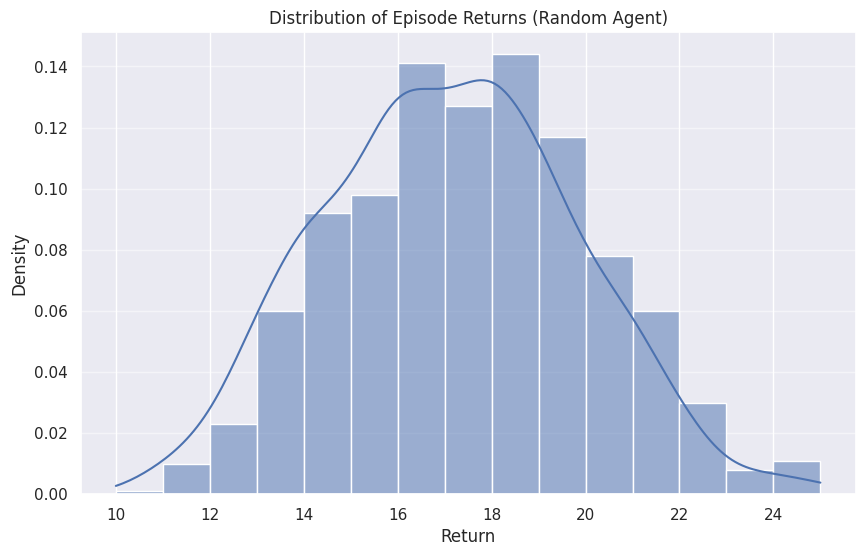

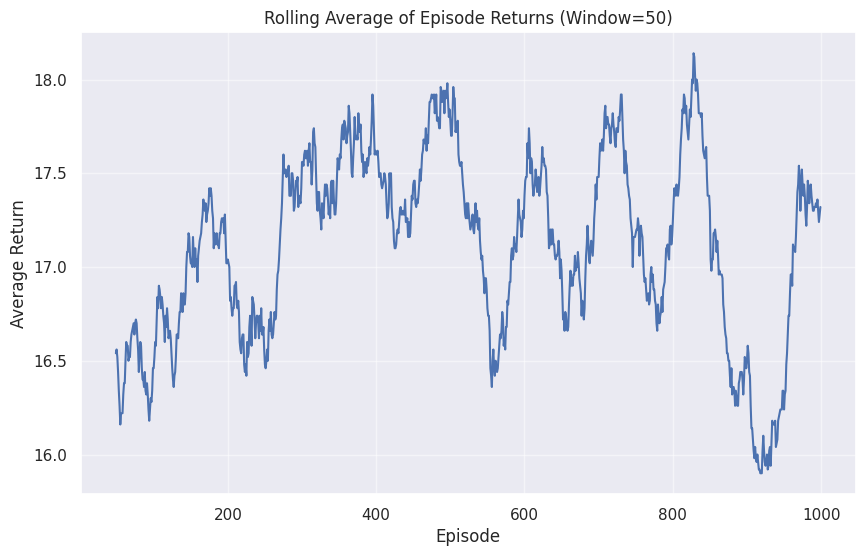

In [13]:
# Training parameters
n_episodes = 1000
all_returns = []
total_steps = 0

print(f"Running {n_episodes} episodes with a Random Agent...")

# --- Main Loop ---
for episode in range(n_episodes):
    episode_return = 0

    # Reset the environment for a new episode
    observation, info = env.reset()

    terminated = False
    truncated = False

    # Run the episode
    while not terminated and not truncated:
        # 1. Select a random action (our "Random Agent")
        action = env.action_space.sample()

        # 2. Step the environment with the action
        observation, reward, terminated, truncated, info = env.step(action)

        # 3. Book-keeping
        episode_return += reward
        total_steps += 1

    # --- End of Episode ---
    all_returns.append(episode_return)

    # Log results every 100 episodes to avoid too much output
    if (episode + 1) % 100 == 0:
        print(f"Episode: {episode + 1}/{n_episodes} | Return: {episode_return:.2f} | Total Steps: {total_steps}")


clear_output(wait=True)
print("✅ All episodes completed.")
print(f"Total steps taken: {total_steps}")
print(f"Average return per episode: {np.mean(all_returns):.2f}")


# --- Final Plot ---
# Histogram of all returns
plt.figure(figsize=(10, 6))
sns.histplot(all_returns, stat="density", kde=True, bins=15)
plt.title('Distribution of Episode Returns (Random Agent)')
plt.xlabel('Return')
plt.ylabel('Density')
plt.grid(axis='y', alpha=0.5)
plt.show()

# Also show a rolling average of returns to see if there was any learning
# (There won't be for a random agent, but this is good practice)
rolling_avg = pd.Series(all_returns).rolling(window=50).mean()
plt.figure(figsize=(10, 6))
plt.plot(rolling_avg)
plt.title('Rolling Average of Episode Returns (Window=50)')
plt.xlabel('Episode')
plt.ylabel('Average Return')
plt.grid(True, alpha=0.5)
plt.show()

**Note:** You can simplify the environment loop using [Stable-Baselines3](https://stable-baselines3.readthedocs.io/en/master/index.html).

In [14]:
env = NBack(N=2, episode_steps=32)
monitored_env = Monitor(env, log_dir)

Define the network architecture

In [15]:
policy_kwargs = dict(
    net_arch=[50, 50]  # Two hidden layers with 50 neurons each
)

Construct the DQN agent

In [16]:
# - 'MlpPolicy': Use a standard Multi-Layer Perceptron policy.
# - env: The environment instance for the agent to learn in.
# - policy_kwargs: Our custom network architecture.
# - learning_rate: The step size for the optimizer.
# - buffer_size: The size of the replay buffer.
# - exploration_initial_eps/exploration_final_eps: To mimic the original
#   constant epsilon=0.5, we set both to 0.5. For real training, you would
#   typically anneal this from 1.0 down to a small value.
# - verbose=1: To print training information.
# - tensorboard_log: Directory for saving TensorBoard logs.
#
agent = DQN(
    policy='MlpPolicy',
    env=monitored_env,
    policy_kwargs=policy_kwargs,
    learning_rate=1e-4,
    buffer_size=10000,
    learning_starts=100, # Number of steps to collect before training starts
    batch_size=32,
    train_freq=(1, "step"),
    target_update_interval=250,
    exploration_fraction=0.5, # Not very relevant if initial and final eps are the same
    exploration_initial_eps=0.5,
    exploration_final_eps=0.5,
    verbose=1,
    tensorboard_log="./nback_dqn_tensorboard/"
)

Using cpu device
Wrapping the env in a DummyVecEnv.


Inspect the agent

In [17]:
print("\n--- Agent's Network Architecture ---")
print(agent.policy)
print("\nAgent created successfully!")


--- Agent's Network Architecture ---
DQNPolicy(
  (q_net): QNetwork(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (q_net): Sequential(
      (0): Linear(in_features=32, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=2, bias=True)
    )
  )
  (q_net_target): QNetwork(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (q_net): Sequential(
      (0): Linear(in_features=32, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=2, bias=True)
    )
  )
)

Agent created successfully!


Train the agent

In [18]:
n_episodes = 1000
episode_steps = 32
total_timesteps = n_episodes * episode_steps

print(f"🚀 Starting training for {total_timesteps} timesteps...")
agent.learn(total_timesteps=total_timesteps)
print("✅ Training complete.")


🚀 Starting training for 32000 timesteps...
Logging to ./nback_dqn_tensorboard/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | 15.8     |
|    exploration_rate | 0.5      |
| time/               |          |
|    episodes         | 4        |
|    fps              | 567      |
|    time_elapsed     | 0        |
|    total_timesteps  | 128      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.259    |
|    n_updates        | 27       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 32       |
|    ep_rew_mean      | 17.9     |
|    exploration_rate | 0.5      |
| time/               |          |
|    episodes         | 8        |
|    fps              | 480      |
|    time_elapsed     | 0        |
|    total_timesteps  | 256      |
| train/              |          |
|    l

Plot agent's result

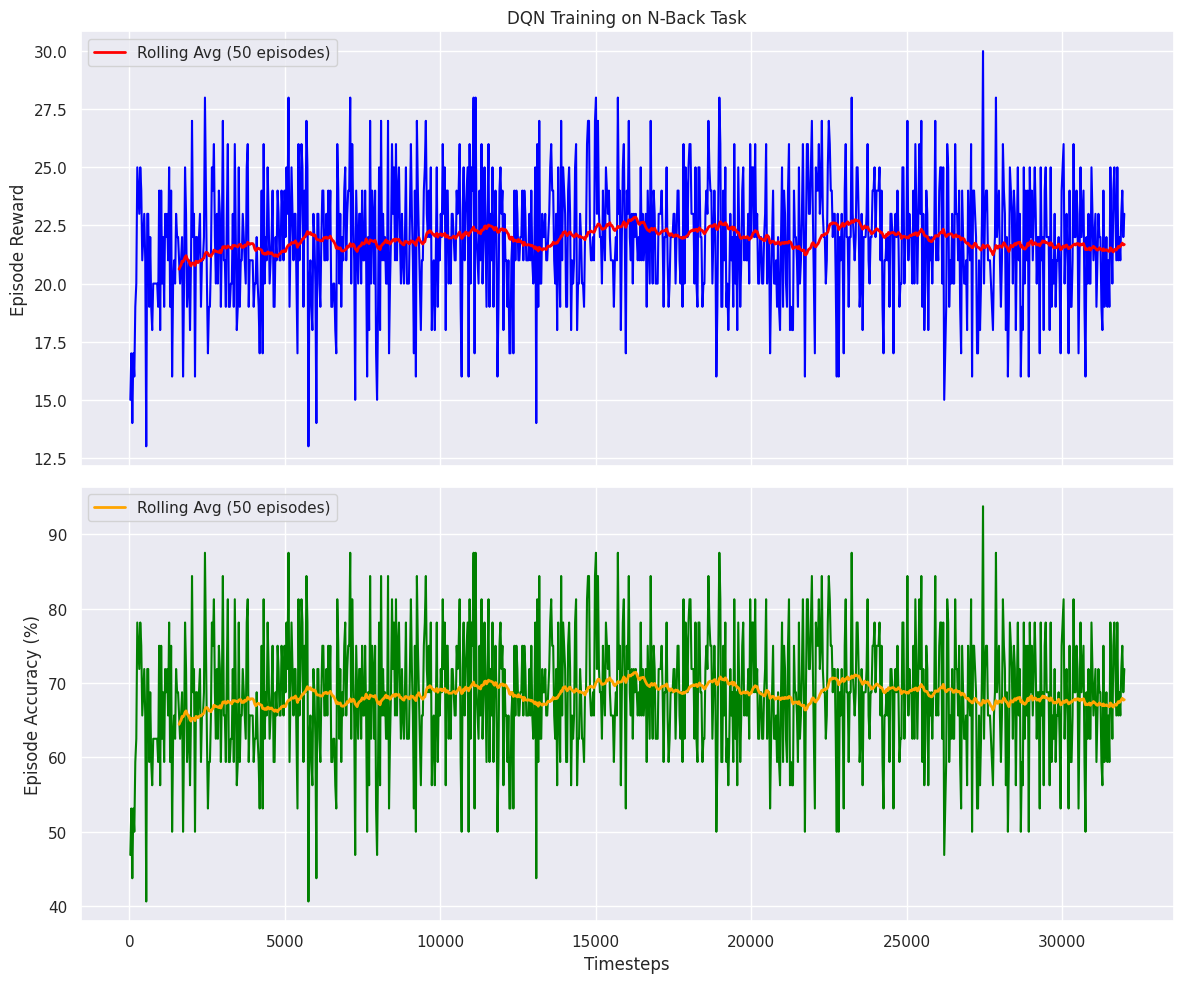

In [19]:
plot_training_results(log_dir, "DQN Training on N-Back Task")

Inspect logs as dataframe

In [20]:
log_file_path = os.path.join(log_dir, "monitor.csv")
if os.path.exists(log_file_path):
    logs_df = pd.read_csv(log_file_path, skiprows=1) # Skip the header row
    print("\n--- Training Logs (last 5 episodes) ---")
    print(logs_df.tail())
else:
    print("\nCould not find the monitor log file.")


--- Training Logs (last 5 episodes) ---
        r   l          t
995  21.0  32  73.091478
996  23.0  32  73.160453
997  24.0  32  73.219404
998  22.0  32  73.273850
999  23.0  32  73.332403
